In [1]:
import pandas as pd
import numpy as np
import sys, os
import pickle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
df = pd.read_csv("./dataset/new_bgg_data_after_eda2.csv",encoding="utf-8")
df.drop(columns = ["Rank", "Id", "Name"], inplace = True)

In [3]:
df_ = df.copy()

### Data Engineering

In [4]:
# Year
df_v1 = df_.copy()
before = df_.shape[0]
df_v1.drop(index = df_v1[df_v1.Year < 1600].index, inplace=True)
after = df_v1.shape[0]
print (f"By year, we drop {before - after} entries.")


By year, we drop 202 entries.


In [5]:
# MaxPlayer
df_v2 = df_v1.copy() 
before = df_v1.shape[0]
df_v2.drop(index = df_v2[df_v2.Maxplayers > 20].index, inplace=True)
after = df_v2.shape[0]
print (f"By Max Player, we drop {before - after} entries.")

By Max Player, we drop 244 entries.


In [6]:
# drop artist
df_v3 = df_v2.copy() 
df_v3.drop(columns="Nartist", inplace=True)


In [7]:
# by designer
df_v4 = df_v3.copy() 
# before = df_v3.shape[0]
# df_v4.drop(index = df_v4[df_v4.Ndesign > 7].index, inplace=True)
# after = df_v4.shape[0]
# print (f"By Max Player, we drop {before - after} entries.")

df_v4.drop(columns="Ndesign", inplace=True)


### Dataset split into train, test (+ validation)

In [8]:
test_size = 0.2
random_state = 42

In [59]:
from sklearn.model_selection import train_test_split

def get_Xs_Ys(df, target, exclude, use_val=True):

      assert type(target) == list, "target must be list"
      assert type(exclude) == list, "exclude must be list"

      train, test = train_test_split(
                        df,
                        test_size = test_size,
                        random_state = random_state)
      if use_val:
            train, val = train_test_split(
                              train,
                              test_size = test_size,
                              random_state = random_state)


      get_y = lambda data : data[target]
      get_x = lambda data : data.drop(columns = target + exclude)

      Ys = {"train" : get_y(train),
            "test" : get_y(test)}
      Xs = {"train" : get_x(train),
            "test" : get_x(test)}
      
      if use_val:
            Ys['val'] = get_y(val)
            Xs['val'] = get_x(val)
            
      return Xs, Ys, target
        
Xs, Ys, target_list = get_Xs_Ys(df, ["Users_rated", "Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"])

### Modeling for Problem 1

1. Baseline with mean

In [49]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def eval_models(y_pred, y_true, verbose = False):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    if verbose:
        
        return {"MSE" : mse,
                "RMSE" : rmse,
                "MAE" : mae,
                "R2": r2}
    else:
        return mse, rmse, mae, r2

In [55]:

baseline_Users_rated = [Ys['train'].Users_rated.mean()] * Ys['test'].shape[0]
baseline_Rating = [Ys['train'].Rating.mean()]* Ys['test'].shape[0]
baseline_Complexity = [Ys['train'].Complexity.mean()]* Ys['test'].shape[0]

print(f"[Baseline] Users_rate : {round(baseline_Users_rated[0],2)}, Rating : {round(baseline_Rating[0], 2)}, Complexity : {round(baseline_Complexity[0], 2)}")

pd.DataFrame([eval_models(baseline_Rating, Ys["test"].Rating, verbose=True), eval_models(baseline_Complexity, Ys["test"].Complexity, verbose=True)],
             index = ["Rating", "Complexity"])





[Baseline] Users_rate : 865.61, Rating : 6.39, Complexity : 1.98


,MSE,RMSE,MAE,R2
Rating,0.823455,0.907444,0.707303,-0.000047
Complexity,0.689546,0.830389,0.663116,-0.000170


2. Simple Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline

In [13]:
def make_simple_linear(sk_args = {}, lrg_arg = {}):
    return make_pipeline(
        SelectKBest(score_func=f_regression),
        LinearRegression(**lrg_arg),
    )

In [61]:


def result_regress(model, Xs, Ys, y_order):
    
    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns = Xs['train'].columns)
    x_val = pd.DataFrame(scaler.transform(Xs['val']), columns = Xs['val'].columns)
    x_test = pd.DataFrame(scaler.transform(Xs['test']), columns= Xs['test'].columns)
    
    model.fit(x_train, Ys['train'].iloc[:, y_order])
    
    y_pred_train = model.predict(x_train)
    y_pred_val   = model.predict(x_val)
    y_pred_test  = model.predict(x_test)
    
    eval_train = eval_models(y_pred_train, Ys['train'].iloc[:, y_order])
    eval_val = eval_models(y_pred_val, Ys['val'].iloc[:, y_order])
    eval_test = eval_models(y_pred_test, Ys['test'].iloc[:, y_order])


    return pd.DataFrame([eval_train, eval_val, eval_test], columns=["MSE", "RMSE", "MAE", "R2"], index = ["train", "validation", "test"]) 


In [15]:
result_regress(make_simple_linear(), Xs, Ys, 0)   

,MSE,RMSE,MAE,R2
train,1.162752e+07,3409.915657,1145.057381,0.165537
validation,1.064322e+07,3262.395352,1133.234640,0.103556


In [62]:
target1 = result_regress(make_simple_linear(), Xs, Ys, 1)   
target1

,MSE,RMSE,MAE,R2
train,0.606281,0.778640,0.597537,0.293833
validation,0.591438,0.769050,0.589534,0.313375
test,0.618930,0.786721,0.605074,0.276769


In [63]:
target2 = result_regress(make_simple_linear(), Xs, Ys, 2)   
target2

,MSE,RMSE,MAE,R2
train,0.354064,0.595032,0.454576,0.484550
validation,0.332355,0.576502,0.438211,0.494751
test,0.347504,0.589494,0.453749,0.504061


In [73]:
simple_test = pd.concat([target1.loc['test'], target2.loc['test']], axis=1).T
simple_test.index=["Rating", "Complexity"]
simple_test

,MSE,RMSE,MAE,R2
Rating,0.618930,0.786721,0.605074,0.276769
Complexity,0.347504,0.589494,0.453749,0.504061


In [18]:
make_simple_linear()

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000021682C0C670>)),
                ('linearregression', LinearRegression())])

In [19]:

from sklearn.model_selection import GridSearchCV

def find_best_k(df, results=False):
    params = {
        
        'selectkbest__k' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        
    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Users_rated", "Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns=Xs['train'].columns)
    
    grid_searchs = []

    for i in tqdm(range(len(target_list))):
        grid_search = GridSearchCV(make_simple_linear(), param_grid=params, scoring="r2", cv=5, verbose=1)
        grid_search.fit(x_train, Ys['train'].iloc[:, i])

        grid_searchs.append(grid_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", grid_search.best_params_)
        print("Best R2 Score: ", grid_search.best_score_)
    
    if results:
        return grid_searchs, scaler

In [20]:
find_best_k(df) # with no enginering

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.18866101011297445
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.3683069909599011
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6013729930439119


In [21]:
find_best_k(df_v1) # with engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.1936807997224337
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.39085518008709574
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6061799210222591


In [22]:
find_best_k(df_v2) # with engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.19051308387083404
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.4052769115551394
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.6152704773680252


In [23]:
linear_model, scaler_v3 = find_best_k(df_v3, results=True) # with engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.18382770306630755
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Rating
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.4058735846707776
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6154452453177555


In [24]:
def test_eval(x_test, y_test, model, target_list, scaler = None):
    
    if scaler is not None:
        x_test = x_test.copy()
        x_test = scaler.transform(x_test)
        x_test = pd.DataFrame(x_test, columns = Xs['test'].columns)
    
    eval_tests = []
    for i in range(len(target_list)):

        eval_test = eval_models(model[i].predict(x_test), Ys['test'][target_list[i]])
        eval_tests.append(eval_test)

    return pd.DataFrame(eval_tests, index=target_list, columns=["MSE", "RMSE", "MAE", "R2"])

In [25]:
Xs, Ys, target_list = get_Xs_Ys(df_v3, ["Users_rated", "Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

In [26]:
simple_linear_test_eval = test_eval(Xs['test'], Ys['test'], linear_model, target_list, scaler = scaler_v3)

In [27]:
simple_linear_test_eval

,MSE,RMSE,MAE,R2
Users_rated,8.990830e+06,2998.471218,1106.675445,0.208177
Rating,5.257300e-01,0.725072,0.540702,0.361526
Complexity,2.781551e-01,0.527404,0.375051,0.596543


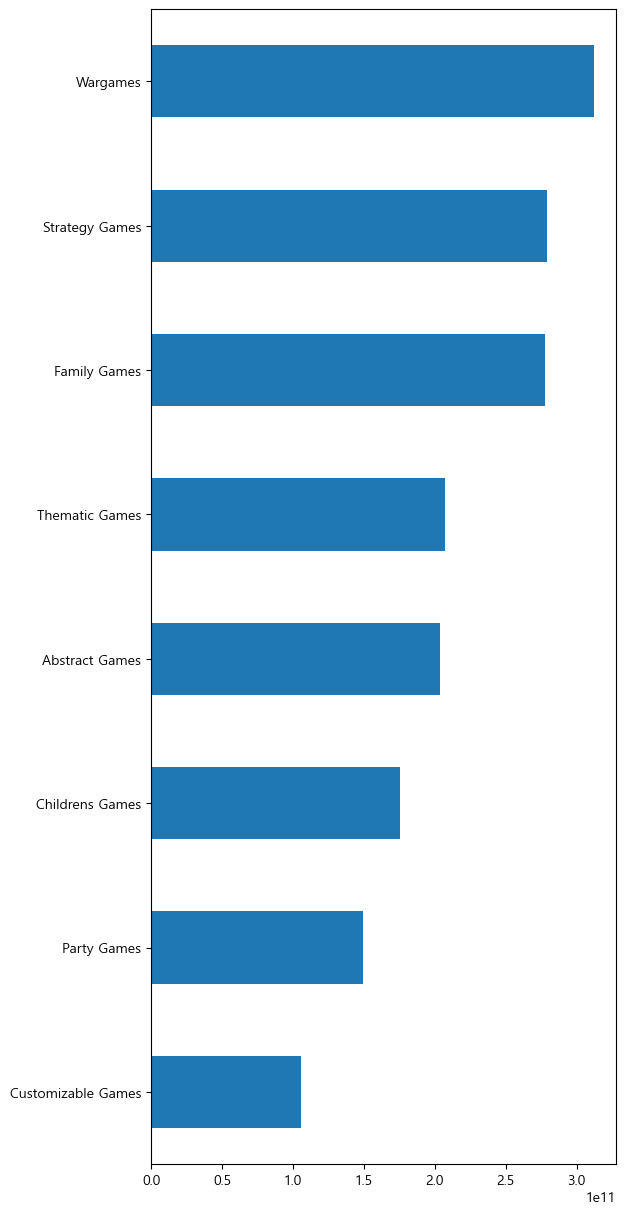

In [28]:
# check last model about Complexity
plt.rcParams['font.family'] = 'Malgun Gothic'
coef_ = pd.Series(linear_model[2].best_estimator_['linearregression'].coef_,
          index = linear_model[2].best_estimator_['selectkbest'].get_feature_names_out()).sort_values(ascending=False)
coef_[:8].sort_values().plot.barh(figsize=(6, 15))
plt.show()

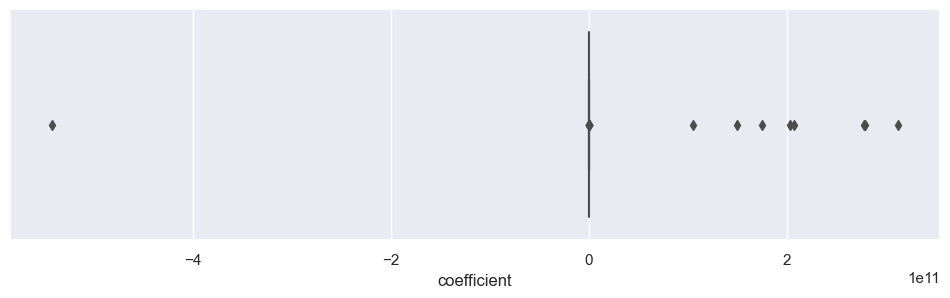

In [29]:
# 엄청나게 비대칭적인 계수 현황
sns.set(rc={'figure.figsize':(12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()

2. 1. regression with y = $\frac{C}{f(X)}$

In [30]:
def find_best_k_inverse(df, c=1e+6, results=False):
    params = {
        
        'selectkbest__k' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        
    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Users_rated"], ["Sug_players", "Sug_age", "Language_dependence", "Own", "Rating", "Complexity"], use_val=False)

    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns=Xs['train'].columns)
    
    grid_searchs = []

    for i in tqdm(range(len(target_list))):
        grid_search = GridSearchCV(make_simple_linear(), param_grid=params, scoring="r2", cv=5, verbose=1)
        grid_search.fit(x_train, c/Ys['train'].iloc[:, i])

        grid_searchs.append(grid_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", grid_search.best_params_)
        print("Best R2 Score: ", grid_search.best_score_)
    
    if results:
        return grid_searchs, scaler

In [31]:
dataset = [df, df_v1, df_v2, df_v3, df_v4]

for i, data in tqdm(enumerate(dataset)):
    print(f"df_v[{i}] : " ,end="")
    find_best_k_inverse(data, c=1e+5) # with no enginering


0it [00:00, ?it/s]

df_v[0] : 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.30964822772080913
df_v[1] : 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 130}
Best R2 Score:  0.3092608754764505
df_v[2] : 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.3032699643435393
df_v[3] : 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.30556552014577215
df_v[4] : 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Target : Users_rated
Best parameter:  {'selectkbest__k': 150}
Best R2 Score:  0.30414919159806664


3. Linear Regression with Ridge Regularization

In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

In [33]:
def make_ridge(sk_args= {}, rd_args = {}):
    return make_pipeline(
        SelectKBest(score_func=f_regression),
        Ridge(**rd_args, random_state=random_state),
    )
make_ridge()

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000021682C0C670>)),
                ('ridge', Ridge(random_state=42))])

In [34]:
def find_best_param_randomly(df, results=False):
    params = {
        'selectkbest__k' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
        'ridge__alpha' : np.random.uniform(1e-4, 1e+5, 100)
    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Users_rated", "Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

    scaler = StandardScaler()
    
    x_train = pd.DataFrame(scaler.fit_transform(Xs['train']), columns=Xs['train'].columns)

    random_searchs = []
    
    for i in tqdm(range(len(target_list))):
        random_search = RandomizedSearchCV(make_ridge(), params, n_iter = 100,
                                           n_jobs=-1, random_state=random_state, cv=5)
        random_search.fit(x_train, Ys['train'].iloc[:, i])
        
        random_searchs.append(random_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", random_search.best_params_)
        print("Best R2 Score: ", random_search.best_score_)
    
    if results:
        return random_searchs, scaler

In [35]:
find_best_param_randomly(df) # with no engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Target : Users_rated
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 1060.539455047686}
Best R2 Score:  0.1761934322321803
Target : Rating
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 1060.539455047686}
Best R2 Score:  0.36313946063740205
Target : Complexity
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 1060.539455047686}
Best R2 Score:  0.600623193158019


In [36]:
find_best_param_randomly(df_v1) # with engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Target : Users_rated
Best parameter:  {'selectkbest__k': 80, 'ridge__alpha': 1314.759438937932}
Best R2 Score:  0.17420241051605606
Target : Rating
Best parameter:  {'selectkbest__k': 80, 'ridge__alpha': 1314.759438937932}
Best R2 Score:  0.37864851808402655
Target : Complexity
Best parameter:  {'selectkbest__k': 80, 'ridge__alpha': 1314.759438937932}
Best R2 Score:  0.5974209527270515


In [37]:
ridge_model, scaler_v2 = find_best_param_randomly(df_v2, results=True) # with engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Target : Users_rated
Best parameter:  {'selectkbest__k': 120, 'ridge__alpha': 742.569177148595}
Best R2 Score:  0.1701831014820499
Target : Rating
Best parameter:  {'selectkbest__k': 120, 'ridge__alpha': 742.569177148595}
Best R2 Score:  0.39920325548684477
Target : Complexity
Best parameter:  {'selectkbest__k': 120, 'ridge__alpha': 742.569177148595}
Best R2 Score:  0.6149307681452675


In [38]:
find_best_param_randomly(df_v3) # with engineering

  0%|          | 0/3 [00:00<?, ?it/s]

Target : Users_rated
Best parameter:  {'selectkbest__k': 110, 'ridge__alpha': 1681.104226985784}
Best R2 Score:  0.1591878731754009
Target : Rating
Best parameter:  {'selectkbest__k': 110, 'ridge__alpha': 1681.104226985784}
Best R2 Score:  0.3947227329121841
Target : Complexity
Best parameter:  {'selectkbest__k': 110, 'ridge__alpha': 1681.104226985784}
Best R2 Score:  0.6135654044099941


In [39]:
Xs, Ys, target_list = get_Xs_Ys(df_v2, ["Users_rated", "Rating", "Complexity"], ["Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

In [40]:
ridge_test_eval = test_eval(Xs['test'], Ys['test'], ridge_model, target_list, scaler = scaler_v2)

In [41]:
ridge_test_eval

,MSE,RMSE,MAE,R2
Users_rated,9.137755e+06,3022.871906,1075.259778,0.195237
Rating,5.316205e-01,0.729123,0.544429,0.354373
Complexity,2.784578e-01,0.527691,0.375180,0.596104


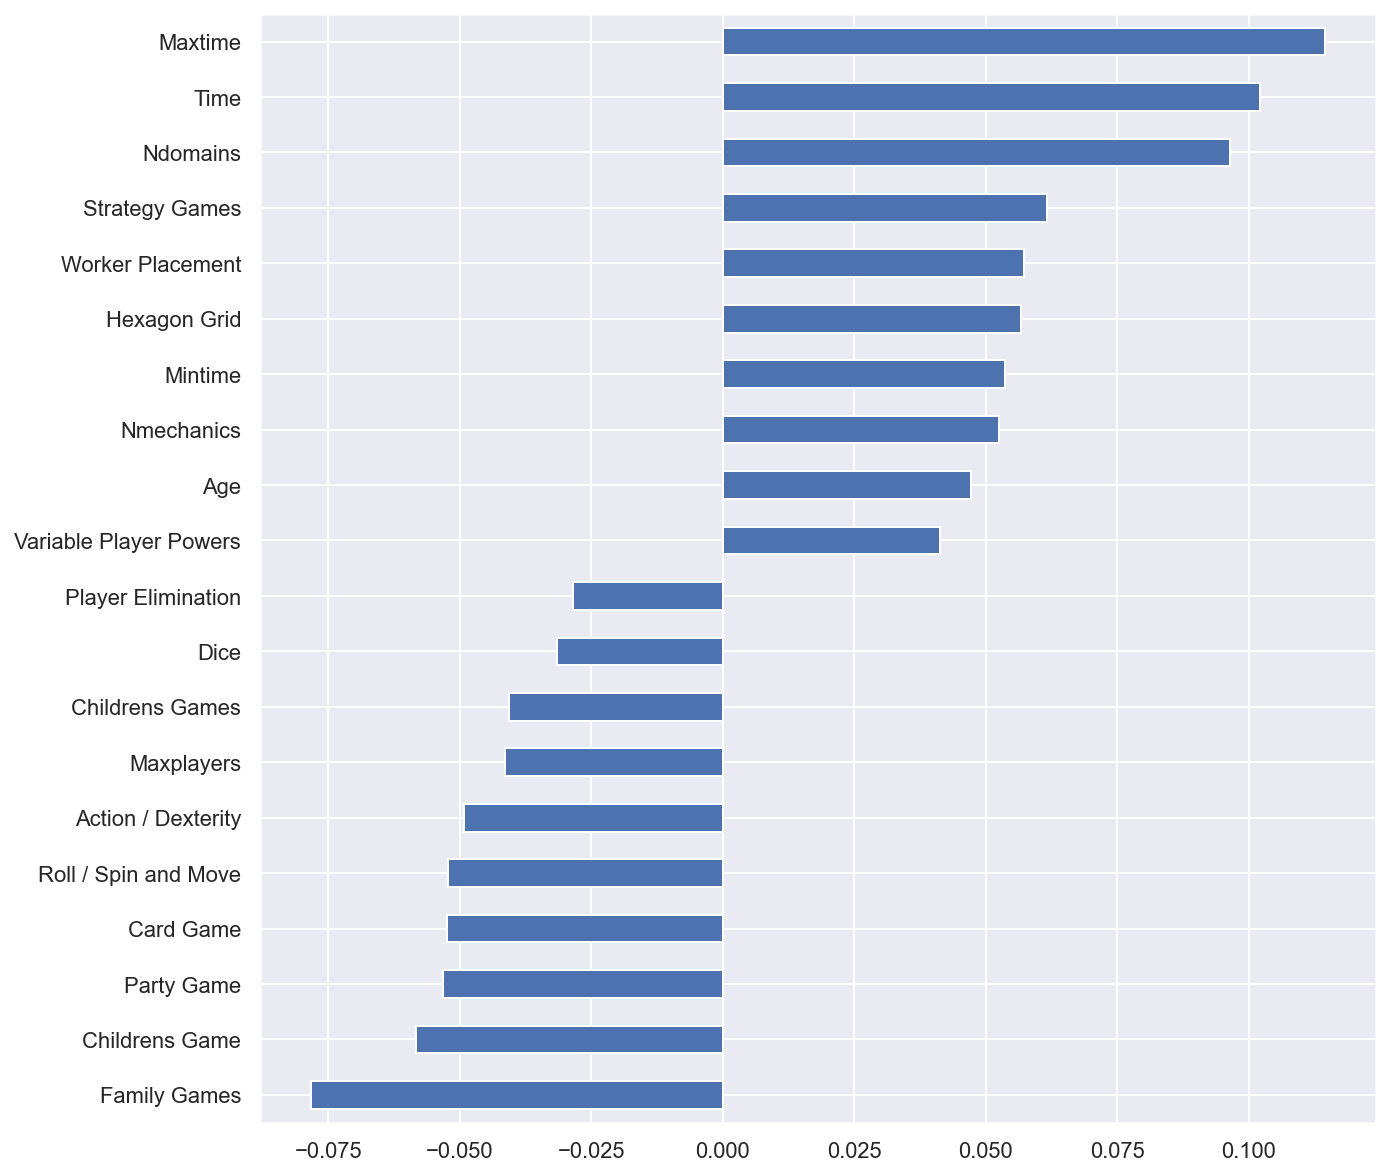

In [48]:
# check last model about Complexity
matplotlib.rcParams['font.family'] = 'sans-serif'
coef_ = pd.Series(ridge_model[2].best_estimator_['ridge'].coef_,
          index = ridge_model[2].best_estimator_['selectkbest'].get_feature_names_out()).sort_values()

pd.concat([coef_.head(10), coef_.tail(10)]).plot.barh(figsize=(10, 10))
plt.show()

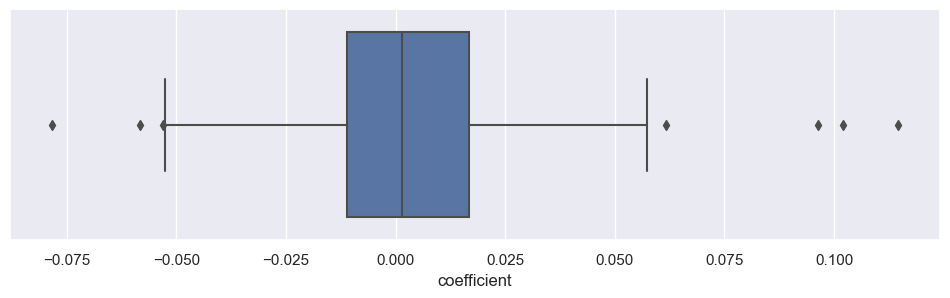

In [43]:
# simple linear에 비해 비교적 대칭적인 회귀계수
sns.set(rc={'figure.figsize':(12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()